In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from sklearn.manifold import TSNE

In [8]:
from torchvision import transforms  # type: ignore
from PIL import Image
from skimage import exposure
from torchvision import datasets, transforms  # type: ignore
from torch.utils.data import DataLoader

def clahe(x: torch.Tensor):
    x = x.numpy()
    x = exposure.equalize_adapthist(x)
    x = torch.from_numpy(x)
    return x

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (0.299 * x[0] + 0.587 * x[1] + 0.114 * x[2]).unsqueeze(0)),
])

val_dataset = datasets.ImageFolder(root='SMDG-19/val', transform=val_transform)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, num_workers=0)

In [9]:
LATENTS = [64, 128, 256]

In [11]:
from model.hvae import HVAE
import torch

models = []
for _, lat in enumerate(LATENTS):
    vae_model = HVAE(
        initial_image_size=128,
        input_channels=1,
        output_channels=1,
        encoder_hidden_dims=[32] + [64, 128],
        latent_dims=[lat],
        learning_rate=1e-4,
        beta=2,
        stride=2,
    )

    for param in vae_model.parameters():
        param.requires_grad = False

    vae_model.load_state_dict(
        torch.load(
            f'im_128_enc_32_64_128_lat_{lat}_beta_2.ckpt'
        )['state_dict']
    )

    models.append(vae_model)

Encoder:
	1 -> 32, stride=1
	32 -> 64, stride=2
	64 -> 128, stride=2
LatentSpace:
	131072 (flattened) -> 64
Decoder input:
	64 -> 131072 (flattened)
Decoder:
	128 -> 64, stride=2
	64 -> 32, stride=2
	32 -> 1, stride=1
weights_sum / before_weights_sum: 0.912322998046875
Encoder:
	1 -> 32, stride=1
	32 -> 64, stride=2
	64 -> 128, stride=2
LatentSpace:
	131072 (flattened) -> 128
Decoder input:
	128 -> 131072 (flattened)
Decoder:
	128 -> 64, stride=2
	64 -> 32, stride=2
	32 -> 1, stride=1
weights_sum / before_weights_sum: 0.912322998046875
Encoder:
	1 -> 32, stride=1
	32 -> 64, stride=2
	64 -> 128, stride=2
LatentSpace:
	131072 (flattened) -> 256
Decoder input:
	256 -> 131072 (flattened)
Decoder:
	128 -> 64, stride=2
	64 -> 32, stride=2
	32 -> 1, stride=1
weights_sum / before_weights_sum: 0.912322998046875


In [12]:
z_s_s = []
l_s_s = []

for i, lat in enumerate(LATENTS):
    print(f"Running latent={lat}...")
    z_s = []
    l_s = []

    for _, (x, l) in enumerate(val_dataloader):
        embd = models[i].encoder(x)
        mus, logvars = models[i].latent_space(embd)
        z = models[i].latent_space.reparameterize(mus[-1], logvars[-1])

        z_s.append(z.detach().numpy())
        l_s.append(l.detach().numpy())

    z_s = np.concatenate(z_s)
    l_s = np.concatenate(l_s)

    z_s_s.append(z_s)
    l_s_s.append(l_s)

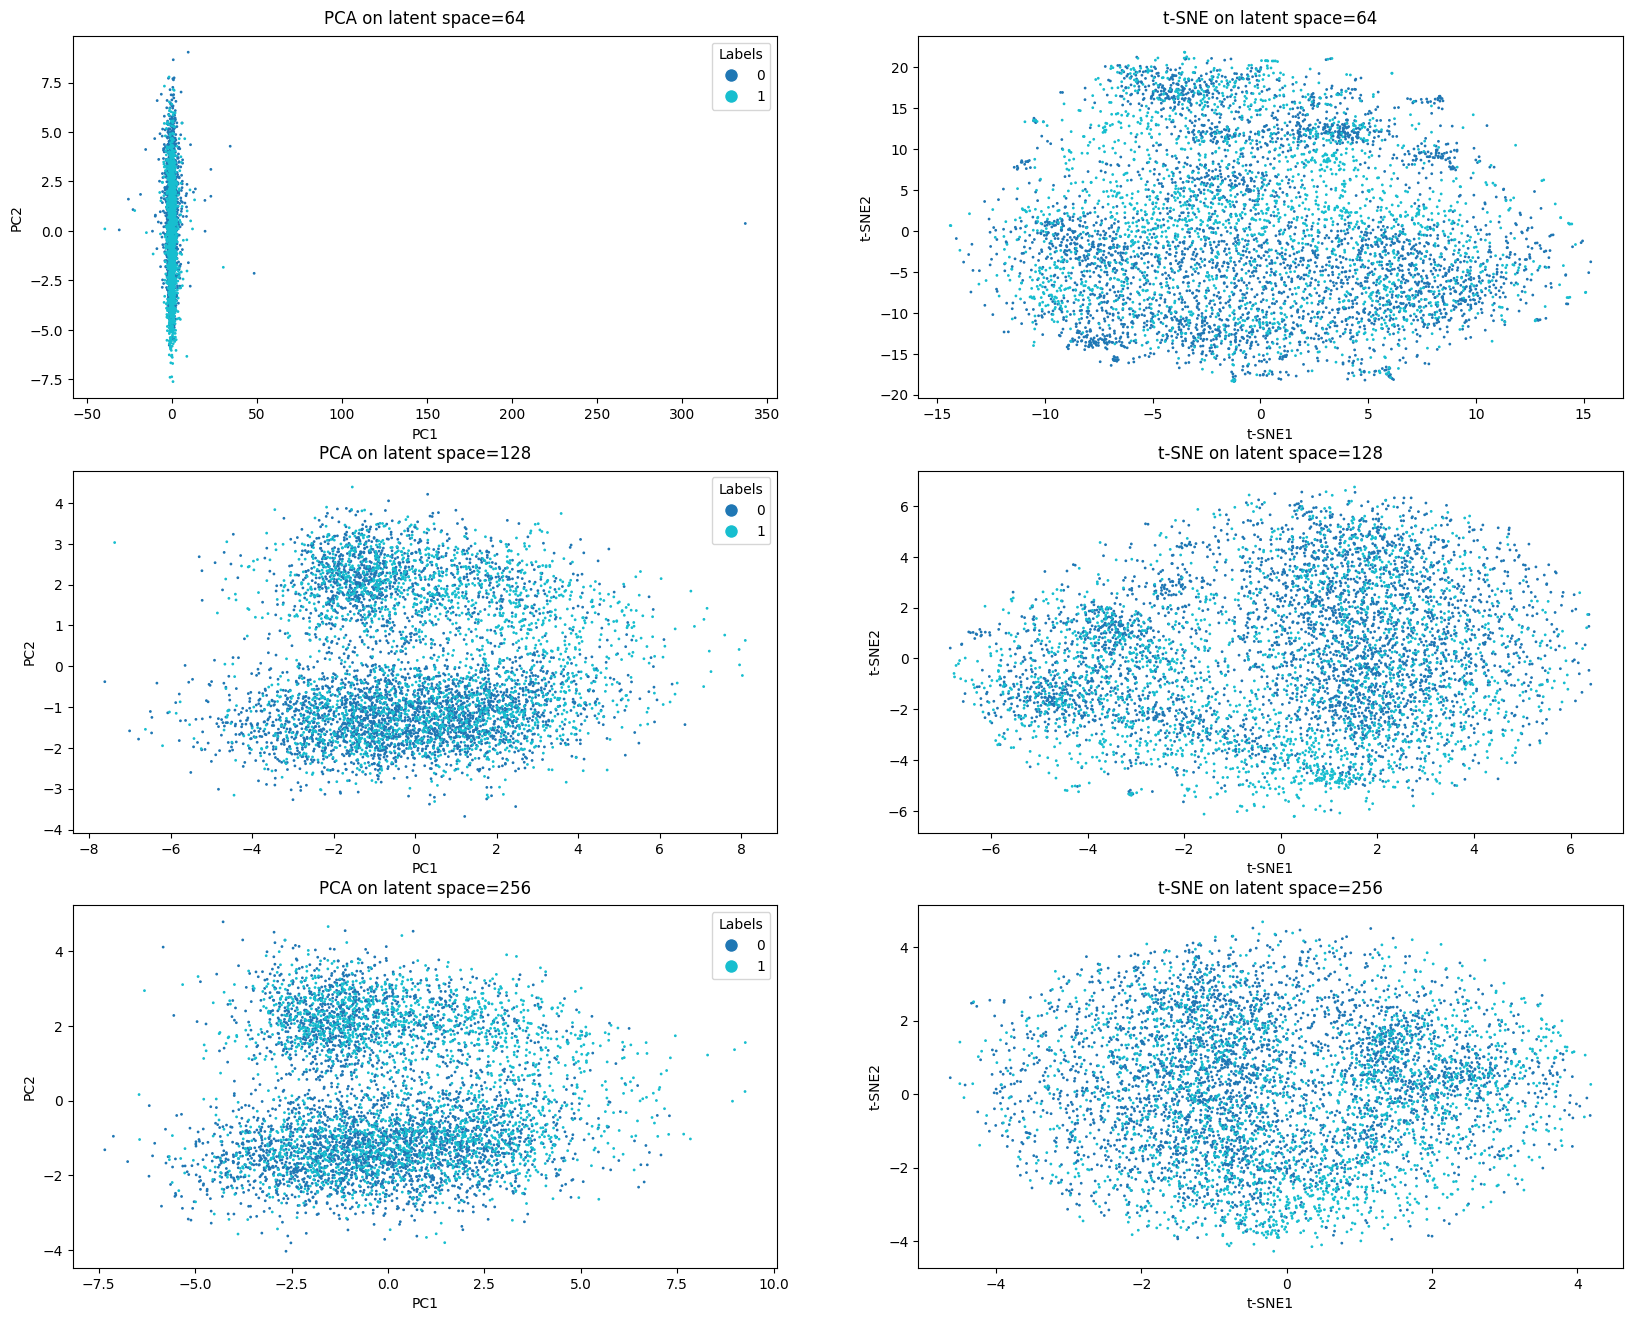

In [26]:
fig, ax = plt.subplots(nrows=len(LATENTS), ncols=2, figsize=(20, 16))
axes = ax.flatten()

for i, lat in enumerate(LATENTS): 
    z_s = z_s_s[i]
    l_s = l_s_s[i]

    ax1 = axes[2*i]
    ax2 = axes[2*i+1]

    # PCA
    pca = PCA(n_components=2)
    pca.fit(z_s)
    pca_results = pca.transform(z_s)

    ax1.scatter(pca_results[:, 0], pca_results[:, 1], c=l_s, cmap='tab10', alpha=1.0, s=1)
    ax1.set_title(f'PCA on latent space={lat}', y=1.01)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=100, random_state=42)
    tsne_results = tsne.fit_transform(z_s, l_s)

    ax2.scatter(tsne_results[:, 0], tsne_results[:, 1], c=l_s, cmap='tab10', alpha=1.0, s=1)
    ax2.set_title(f't-SNE on latent space={lat}', y=1.01)
    ax2.set_xlabel('t-SNE1')
    ax2.set_ylabel('t-SNE2')

    # Legend
    unique_labels = np.unique(l_s)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=plt.cm.tab10(label / max(unique_labels)), markersize=10) for label in unique_labels]
    ax1.legend(handles=handles, title='Labels', loc='upper right')

plt.show()

## Are examples from different classes in different clusters?

Well, not really. There are some small clusters of 0 class, and as a method of 'figuring out' 1s we could check if they were not in those clusters, which is especially visible on t-SNE, latent=64.

The PCA on latent=64, did not do much :(